In [1]:
%matplotlib widget
import os
# Avoid Tensorflow yelling
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from copy import deepcopy
from numpy.lib.stride_tricks import sliding_window_view
from pe_extractor.cnn import generator_nsb
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import tensorflow as tf

import importlib
import signal_sense
from signal_sense import accuracy_m, precision_m, recall_m, f1_m, get_model_summary
import pyeventio_binary_reader
from pyeventio_binary_reader import *

importlib.reload(signal_sense)
importlib.reload(pyeventio_binary_reader)

<module 'pyeventio_binary_reader' from '/mnt/c/Users/yannis/Desktop/Hepia/Year4/projet_semestre_terzina/signal_sense/pyeventio_binary_reader.py'>

# Pe Extractor data visualisation

In [11]:
# generator variables
n_sample = 200000
n_sample_init = 0
batch_size = 1
shift_proba_bin = 30
sigma_smooth_pe_ns = 0 #2.
bin_size_ns = 0.20
sampling_rate_mhz = 1000 #200 MHz is the sampling rate of terzina
                        #250 SST1M
                        #1000 LST + MST
                        #résolution 100 picosecondes 
pe_rate_mhz = 150 # 1 to 150 MHz
noise_lsb=4. # 3.5 to 5.5 options
amplitude_gain=16.
relative_gain_std=0.05
# -------------------------------
# Generator data
# -------------------------------
sampling_period_s = 1 / (sampling_rate_mhz * 1e6)
bin_per_sample = ceil(((sampling_period_s) * 1e9) / bin_size_ns)

gen = generator_nsb(
    n_event=None, batch_size=batch_size, n_sample=n_sample + n_sample_init,
    n_sample_init=n_sample_init, pe_rate_mhz=pe_rate_mhz,
    bin_size_ns=bin_size_ns, sampling_rate_mhz=sampling_rate_mhz,
    amplitude_gain=amplitude_gain, noise_lsb=noise_lsb,
    sigma_smooth_pe_ns=sigma_smooth_pe_ns, baseline=0,
    relative_gain_std=relative_gain_std, shift_proba_bin=shift_proba_bin, dtype=np.float64,
    template_path='pulse_templates/LST_template_3ns.txt'
)

print(f"Using sampling period of {sampling_period_s}s")
print(f"Having {((sampling_period_s) * 1e9) / bin_size_ns} --> {bin_per_sample} bins for every sample")

Using sampling period of 1e-09s
Having 5.0 --> 5 bins for every sample


In [34]:
# Model dependant variables
train_size = int(0.8 * n_sample)
window_size = 21
conv_size = 11

data = next(gen)
summed_bins = np.sum(data[1][0].reshape(-1, bin_per_sample), axis=1)
print("Generated data : ", data[0][0].shape)
print("Generated outputs : ", summed_bins.shape)
# summed_bins_bool = list(map(lambda x: 1 if x > 0 else 0, summed_bins))


sample_weights = signal_sense.compute_sample_weights(summed_bins)
print("Generated weights : ", sample_weights.shape)

sliced_data = sliding_window_view(data[0][0], window_size)
sliced_results = sliding_window_view(summed_bins, window_size)
sliced_weights = np.average(sliding_window_view(sample_weights, window_size), axis=1)
print(f"Sliced : data={sliced_data.shape}, results={sliced_results.shape}, weights={sliced_weights.shape}")
# print(sliced_weights)

# split the data into training/test data
dataset = list(zip(deepcopy(sliced_data), deepcopy(sliced_results), deepcopy(sliced_weights)))
# np.random.shuffle(dataset)

train_dataset, val_dataset = dataset[:train_size], dataset[train_size:]
np.random.shuffle(train_dataset)
train_data, train_results, train_weights = zip(*train_dataset)
train_data, train_results, train_weights = np.asarray(train_data), np.asarray(train_results), np.asarray(train_weights)
val_data, val_results, val_weights = zip(*val_dataset)
val_data, val_results, val_weights = np.asarray(val_data), np.asarray(val_results), np.asarray(val_weights)
print(f"Train : data={train_data.shape}, results={train_results.shape}, weights={train_weights.shape}")
print(f"Validation : data={val_data.shape}, results={val_results.shape}, weights={val_weights.shape}")

Generated data :  (200000,)
Generated outputs :  (200000,)
Generated weights :  (200000,)
Sliced : data=(199980, 21), results=(199980, 21), weights=(199980,)
Train : data=(160000, 21), results=(160000, 21), weights=(160000,)
Validation : data=(39980, 21), results=(39980, 21), weights=(39980,)


/tmp/ipykernel_1857/797270927.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 5))


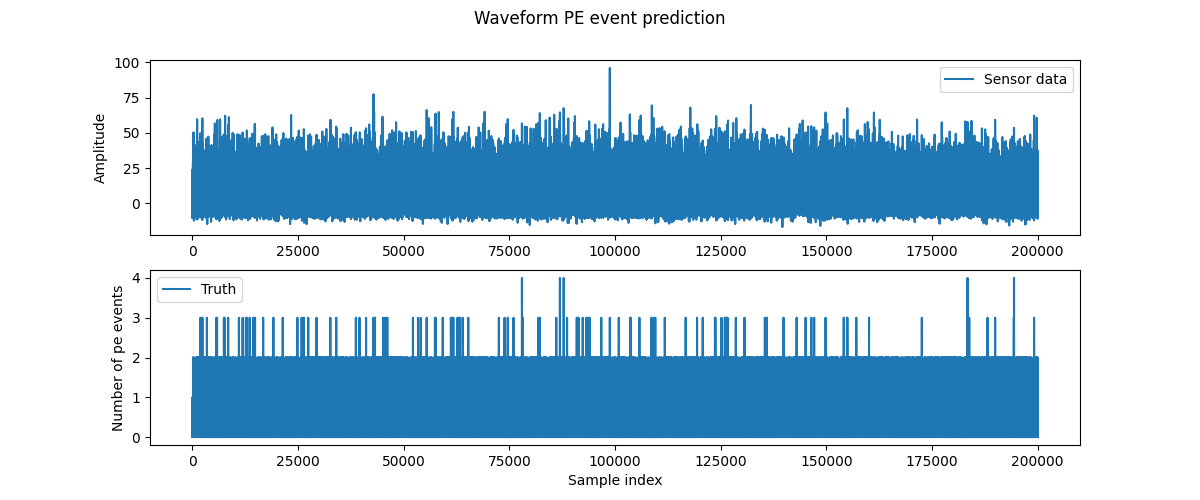

In [45]:
# --------------------------------
# Whole waveform display
# --------------------------------

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Waveform PE event prediction')
ax1 = plt.subplot(211)
ax1.plot(data[0][0], label='Sensor data')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylabel('Number of pe events')
ax2.plot(summed_bins, label='Truth')
# results = model.predict(sliced_data)
# avg_results = signal_sense.reaggregate_windows_avg(results, window_size, window_size-1)
# ax2.plot(avg_results, label='Prediction')
ax2.legend()
plt.xlabel('Sample index')

plt.show()

# Corsika simulation file waveform visualisation

In [11]:
# load event from file
sevent = simevent_from_file("./data/bin_data/gamma_ev1_out.bin", 0)
print(sevent)

Parsing ./data/bin_data/gamma_ev1_out.bin
event_id : 1
energy : 0.06481422483921051
n_pe : 311
n_pixels : 77
nn_PMT_channels : 7987
nn_fadc_point : 75
fadc_sample_in_ns : 0.9765625
NGB_rate_in_MHz : 268.0
fadc_electronic_noise_RMS : 3.8082497119903564
channel_waveforms : (7987, 75)
channel_pe_truths : (7987, 75)


[[  42]
 [6664]
 [6665]
 [6666]
 [6667]
 [6675]
 [6676]
 [6919]]


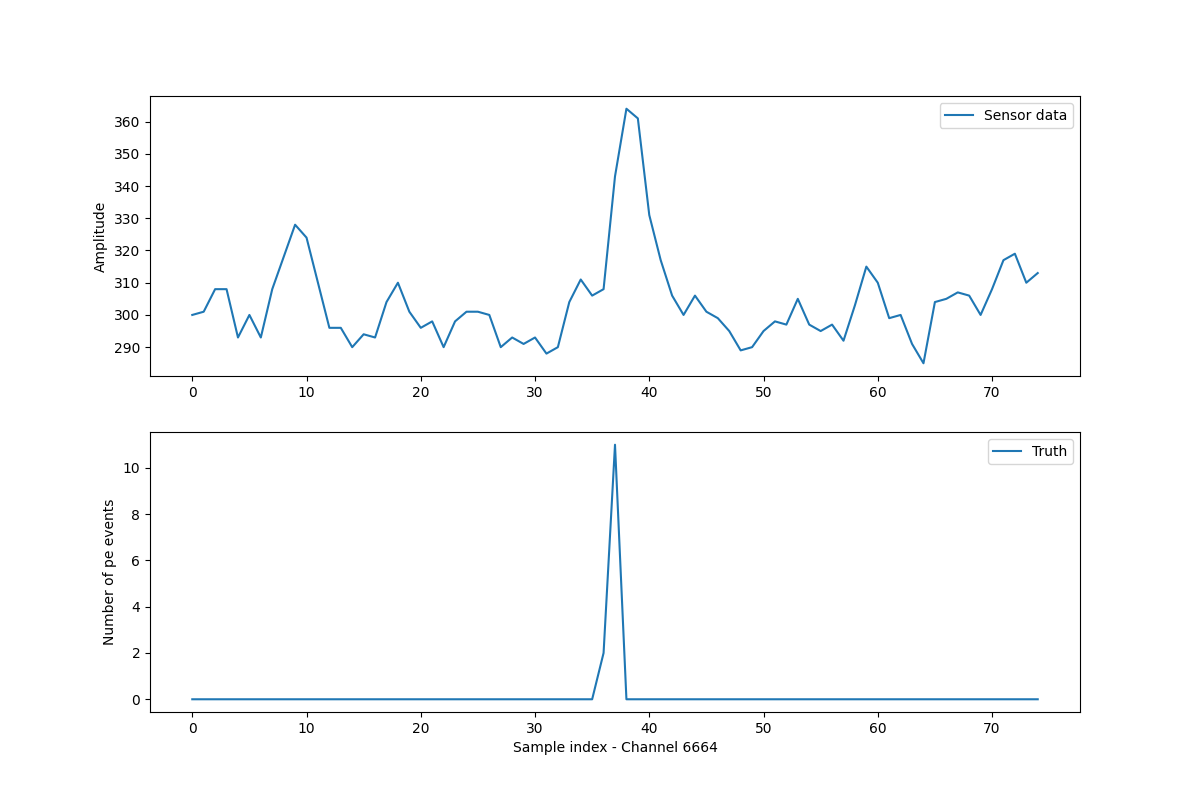

In [12]:
# --------------------------------
# Channel sliding window display (for verification) 
# --------------------------------
i = 6664
j = 0
fig = plt.figure(figsize=(12, 8))

# find sample that are not 0
# non_null_x = np.argwhere(np.sum(sevent.channel_pe_truths, axis=1) > 10)
# print(non_null_x)

window_size = 21
sig_win, truth_win = sevent.waveform_windows(window_size)

def update():
    plt.clf()
    
    # win_x = np.arange(j,j+window_size)
    
    ax1 = plt.subplot(211)
    ax1.plot(sevent.channel_waveforms[i], label='Sensor data')
    # ax1.plot(win_x, sig_win[i][j], label='Windowed sensor data')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    
    ax2 = plt.subplot(212, sharex=ax1)
    ax2.plot(sevent.channel_pe_truths[i], label='Truth')
    # ax2.plot(win_x, truth_win[i][j], label='Windowed truth')
    ax2.set_ylabel('Number of pe events')
    ax2.legend()
    
    plt.xlabel(f"Sample index - Channel {i}") #  - Window {j}
    plt.draw()

def press(event):
    global i, j
    # Move window left or right
    if event.key == 'left':
        j-=1
    elif event.key == 'right':
        j+=1
    elif event.key == 'up':
        i-=1
        j=0
    elif event.key == 'down':
        i+=1
        j=0
    update()

fig.canvas.mpl_connect('key_press_event', press)
update()
plt.show()

In [14]:
# load event from file
sevent = simevent_from_file("./data/bin_data/gamma_ev1_out.bin")

Parsing ./data/bin_data/gamma_ev1_out.bin


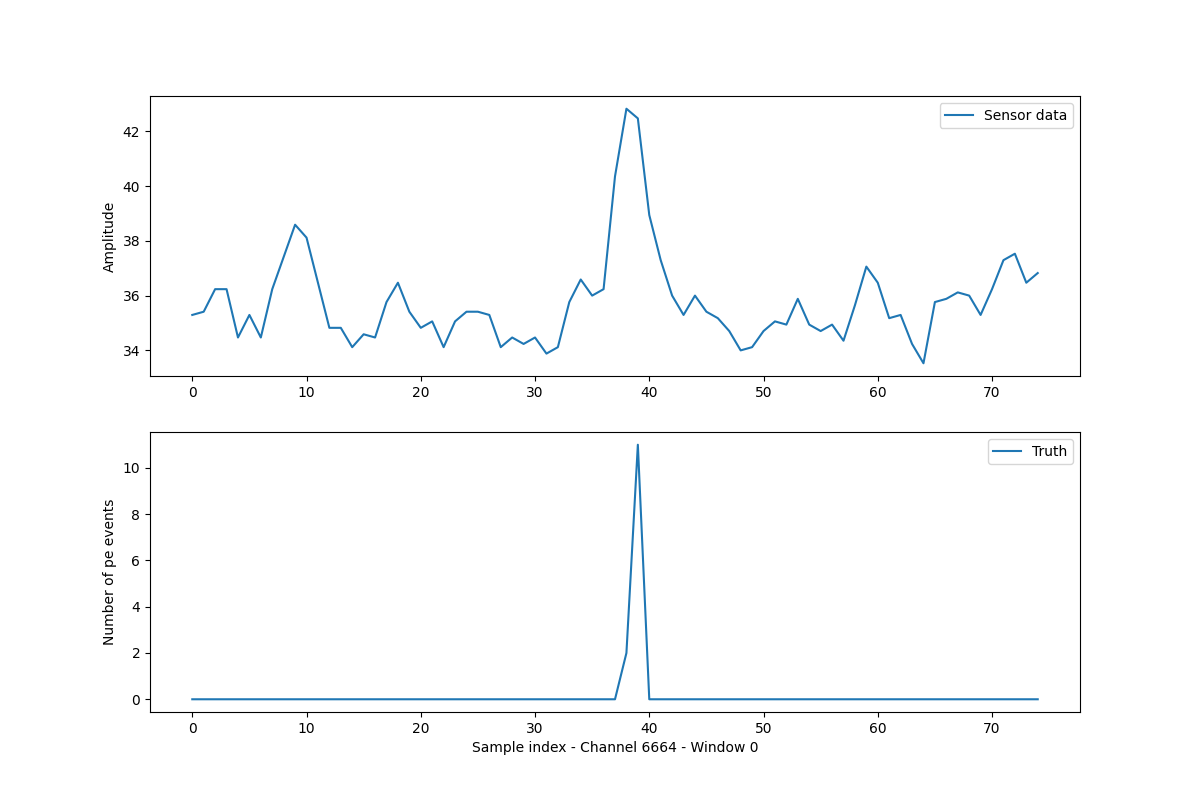

In [17]:
# --------------------------------
# Channel sliding window display with normalisation
# --------------------------------
i = 6664
j = 0
fig = plt.figure(figsize=(12, 8))

# find sample that are not 0
# non_null_x = np.argwhere(np.sum(sevent.channel_pe_truths, axis=1) > 10)
# print(non_null_x)

window_size = 21
sig_win, truth_win = sevent.waveform_windows(window_size)

def update():
    plt.clf()
    
    win_x = np.arange(j,j+window_size)
    
    ax1 = plt.subplot(211)
    ax1.plot(np.array(sevent.channel_waveforms[i]) / 8.5, label='Sensor data')
    # ax1.plot(win_x, np.array(sig_win[i][j]) / 8.5, label='Windowed sensor data')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    
    ax2 = plt.subplot(212, sharex=ax1)
    ax2.plot(sevent.channel_pe_truths[i], label='Truth')
    # ax2.plot(win_x, truth_win[i][j], label='Windowed truth')
    ax2.set_ylabel('Number of pe events')
    ax2.legend()
    
    plt.xlabel(f"Sample index - Channel {i} - Window {j}")
    plt.draw()

def press(event):
    global i, j
    # Move window left or right
    if event.key == 'left':
        j-=1
    elif event.key == 'right':
        j+=1
    elif event.key == 'up':
        i-=1
        j=0
    elif event.key == 'down':
        i+=1
        j=0
    update()

fig.canvas.mpl_connect('key_press_event', press)
update()
plt.show()